In [86]:
from pystencils.session import *
import numpy as np
from matplotlib import patches
import tqdm

In [87]:
r = 26
s = 52
h = 100
l1 = 120
l2 = 120

x = l1+l2+s
y = r+h

domain_size = (x, y)

# create arrays
c_arr = np.zeros(domain_size)
U_arr = np.zeros(domain_size)
D_arr = np.ones(domain_size)
gradU_arr = np.zeros((*domain_size,4))


# create fields
c, c_next, D = ps.fields("c, c_next, D: [2d]", c=c_arr, c_next=c_arr, coordinate_names = ["ρ", "z"])
D, U, gradU = ps.fields("D, U, gradU(4): [2d]", D=D_arr, U=U_arr, gradU=gradU_arr, coordinate_names = ["ρ", "z"])

#J_D, J_A = ps.fields("J_D(2), J_A(2): [2d]", J_D=np.zeros((x,y,2)), J_A = np.zeros((x,y,2)), coordinate_names = ["ρ", "z"])

# cylindrical coordinates curvature
ρ_arr = np.ones(domain_size)
#ρ_arr[:] = np.arange( y, 0, -1)-0.5
#ρ_arr = np.arange(1, y+1)
ρ = ps.fields("ρ: [2d]", ρ = ρ_arr)

In [88]:


#diffusion_rho = 1/ρ[0,0]*δ(ρ[0,0]*D[0,0]*GRAD_C_RHO,RHO)
#advection_rho = 1/ρ[0,0]*δ(ρ[0,0]*D[0,0]*c[0,0]*GRAD_U_RHO,RHO)

#diffusion_z = δ(D[0,0]*GRAD_C_Z,Z)
#advection_z = δ(D[0,0]*c[0,0]*GRAD_U_Z,Z)

#total_change = ps.fd.expand_diff_full(advection_z + advection_rho + diffusion_z + diffusion_rho)*dt
#total_change = ps.fd.expand_diff_full(total_change)

In [89]:
dt = sp.Symbol("dt")
δ = ps.fd.diff 
Z=0
RHO=1
GRAD_C_RHO =δ(c[0,0],RHO)
GRAD_C_Z = δ(c[0,0],Z)
GRAD_U_RHO = δ(U[0,0],RHO)
GRAD_U_Z= δ(U[0,0],Z)

ps.Assignment(gradU[0,0][RHO], GRAD_U_RHO )
ps.Assignment(gradU[0,0][Z], GRAD_U_Z)

#@ps.kernel
#def flux_kernel_desc():
#    J_D[0,0][Z] @= -ps.fd.Discretization2ndOrder(dx = 1)(ps.fd.expand_diff_full(D[0,0]*GRAD_C_Z))
#    J_D[0,0][RHO] @= -ps.fd.Discretization2ndOrder(dx = 1)(ps.fd.expand_diff_full(D[0,0]*GRAD_C_RHO))
#    #J_A[0,0][Z] @= ps.fd.Discretization2ndOrder(dx = 1)(ps.fd.expand_diff_full(D[0,0]*c[0,0]*GRAD_U_Z))
#    #J_A[0,0][RHO] @= ps.fd.Discretization2ndOrder(dx = 1)(ps.fd.expand_diff_full(D[0,0]*c[0,0]*GRAD_U_RHO))

#ast = ps.create_kernel(flux_kernel_desc, cpu_openmp=True)
#flux_kernel = ast.compile()

In [90]:
#flux_kernel_desc

In [91]:
#@ps.kernel
#def concentration_kernel_desc():
#    total_change_rate = -ps.fd.expand_diff_full(δ(J_D[0,0][Z],Z) + δ(J_D[0,0][RHO],RHO))*dt
#    c_next[0,0] @= c[0,0] + ps.fd.Discretization2ndOrder(dx = 1)(total_change_rate.subs(dt, 0.01))

#ast = ps.create_kernel(concentration_kernel_desc, cpu_openmp=True)
#concentration_kernel = ast.compile()

In [92]:
#concentration_kernel_desc

In [93]:
#@ps.kernel
#def concentration_kernel_desc():
#    total_change_rate = -ps.fd.expand_diff_full(δ(J_D[0,0][Z],Z) + δ(J_D[0,0][RHO],RHO))*dt
#    c_next[0,0] @= c[0,0] + ps.fd.Discretization2ndOrder(dx = 1)(total_change_rate.subs(dt, 0.01))
#
#ast = ps.create_kernel(concentration_kernel_desc, cpu_openmp=True)
#concentration_kernel = ast.compile()

In [94]:

adv_term = ps.fields("adv(2): [2d]", adv = np.zeros((x,y,2)), coordinate_names = ["ρ", "z"])
@ps.kernel
def concentration_kernel_desc_2():


    #grad_r = sp.Symbol("grad_r")
    #grad_r = -D[0,0]*GRAD_C_RHO

    div_diffusion = δ(D[0,0]*GRAD_C_Z,Z)*dt + 1/ρ[0,0]*δ(ρ[0,0]*D[0,0]*GRAD_C_RHO,RHO)*dt
    div_advection = δ(c[0,0]*D[0,0]*GRAD_U_Z,Z)*dt + 1/ρ[0,0]*δ(c[0,0]*ρ[0,0]*D[0,0]*GRAD_U_RHO,RHO)*dt
    #div_c = div_diffusion+div_advection
    #grad_z = sp.Symbol("grad_x")
    #grad_r = sp.Symbol("grad_r")
    #grad_z @= D[0,0]*GRAD_U_Z
    #grad_r @= D[0,0]*GRAD_U_RHO
    #adv_term[0,0][Z] @= D[0,0]*GRAD_U_Z
    #adv_term[0,0][RHO] @= D[0,0]*GRAD_U_RHO

    #div = sp.Symbol("div")
    #div @= ps.fd.diffusion(c[0,0],D[0,0]) + ps.fd.advection(c[0,0], adv_term[0,0])
    div = ps.fd.expand_diff_full(div_diffusion+div_advection)

    #c_next[0,0] @= c[0,0] + ps.fd.Discretization2ndOrder(dx = 1)(ps.fd.expand_diff_full(div_c).subs(dt, 0.01))
    #c_next[0,0] @= c[0,0]+ ps.fd.Discretization2ndOrder(dx = 1)(ps.fd.diffusion(c[0,0],D[0,0])*dt).subs(dt, 0.01)
    c_next[0,0] @= c[0,0] + ps.fd.Discretization2ndOrder(dx = 1)(div*dt).subs(dt, 0.01)


concentration_kernel_desc_2

⎡                                                                             
⎢                                                                             
⎢                                                             ⎛U_E   U_W⎞ ⎛c_E
⎢c_next_C := 0.0001⋅D_C⋅c_C⋅(-2⋅U_C + U_E + U_W) + 0.0001⋅D_C⋅⎜─── - ───⎟⋅⎜───
⎣                                                             ⎝ 2     2 ⎠ ⎝ 2 

                                                                              
                                                                              
   c_W⎞                                                ⎛D_E   D_W⎞ ⎛U_E   U_W⎞
 - ───⎟ + 0.0001⋅D_C⋅(-2⋅c_C + c_E + c_W) + 0.0001⋅c_C⋅⎜─── - ───⎟⋅⎜─── - ───⎟
    2 ⎠                                                ⎝ 2     2 ⎠ ⎝ 2     2 ⎠

                                                 ⎛                            
                                          0.0001⋅⎜D_C⋅ρ_C⋅(-2⋅c_C + c_N + c_S)
                ⎛D_E   D_W⎞ ⎛c_E   c_W⎞          ⎝

In [95]:
#div_advection = δ(c[0,0]*D[0,0]*GRAD_U_Z,Z)*dt + 1/ρ[0,0]*δ(c[0,0]*ρ[0,0]*D[0,0]*GRAD_U_RHO,RHO)*dt
#ps.fd.expand_diff_full(div_advection)

In [96]:
ast = ps.create_kernel(concentration_kernel_desc_2, cpu_openmp=True)
concentration_kernel_2 = ast.compile()

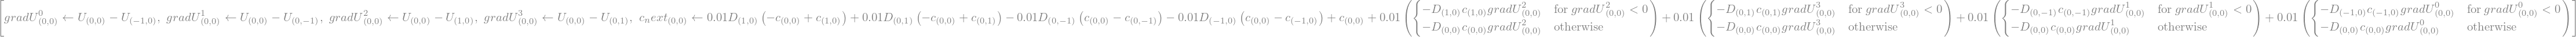

In [97]:
@ps.kernel
def concentration_kernel_3_desc():
    
    #LEFT=-1,0 |0
    #DOWN=0,-1 |1
    #RIGHT=1,0
    #UP=0,1
    #CENTER = 0,0

    #J_z_dif = sp.Symbol(r"J_{z}^{div}")
    #J_rho_dif = sp.Symbol(r"J_{\rho}^{div}")
    
    J_z_dif =   -D[-1,0]*(c[0,0]-c[-1,0]) \
                +D[1,0]*(c[1,0]-c[0,0])
    J_rho_dif = -D[0,-1]*(c[0,0]-c[0,-1]) \
                +D[0,1]*(c[0,1]-c[0,0])
    
    J_dif = J_z_dif+J_rho_dif
    
    #grad_U_left = sp.Symbol(r"\nabla U_{left}")
    #grad_U_left @= U[0,0] - U[-1,0]
    
    #grad_U_right = sp.Symbol(r"\nabla U_{right}")
    #grad_U_right @= U[0,0] - U[1,0]

    gradU[0,0][0] @= U[0,0] - U[-1,0] #left
    gradU[0,0][1] @= U[0,0] - U[0,-1] #down
    gradU[0,0][2] @= U[0,0] - U[1,0]  #right
    gradU[0,0][3] @= U[0,0] - U[0,1] #up


    #J_adv_left = sp.Symbol(r"J_{left}^{adv}")
    J_adv_left = -c[-1,0]*D[-1,0]*gradU[0,0][0] if gradU[0,0][0]<0 else -c[0,0]*D[0,0]*gradU[0,0][0]

    #J_adv_down = sp.Symbol(r"J_{down}^{adv}")
    J_adv_down = -c[0,-1]*D[0,-1]*gradU[0,0][1] if gradU[0,0][1]<0 else -c[0,0]*D[0,0]*gradU[0,0][1]
    
    #J_adv_right= sp.Symbol(r"J_{right}^{adv}")
    J_adv_right = -c[1,0]*D[1,0]*gradU[0,0][2] if gradU[0,0][2]<0 else -c[0,0]*D[0,0]*gradU[0,0][2]

    #J_adv_up= sp.Symbol(r"J_{up}^{adv}")
    J_adv_up = -c[0,1]*D[0,1]*gradU[0,0][3] if gradU[0,0][3]<0 else -c[0,0]*D[0,0]*gradU[0,0][3]

    J_adv = J_adv_up+J_adv_down+J_adv_left+J_adv_right

    
    #J_z_adv = sp.Symbol("J_z^{adv}")
    #J_rho_adv = sp.Symbol("J_z^{rho}")
    #J_z_adv @=   - D[-1,0]*c[-1,0]*(U[0,0]-U[-1,0]) if (U[0,0]==U[-1,0]) else -D[0,0]*c[0,0]*(U[0,0]-U[-1,0]) \
    #            + D[1,0]*c[1,0]*(U[0,0]-U[1,0]) if (U[0,0]==U[1,0]) else D[0,0]*c[0,0]*(U[0,0]-U[1,0])
    
    #J_rho_adv @=  - D[0,-1]*c[0,-1]*(U[0,0]-U[0,-1]) if (U[0,0]==U[0,-1]) else -D[0,0]*c[0,0]*(U[0,0]-U[0,-1]) \
    #            + D[0,1]*c[0,1]*(U[0,0]-U[0,1]) if (U[0,0]==U[0,1]) else D[0,0]*c[0,0]*(U[0,0]-U[0,1])
    #J_rho_adv = -D[0,-1]*c[0,-1]*(U[0,0]-U[0,-1]) - D[0,1]*c[0,1]*(U[0,0]-U[0,1])
    #J_z_adv=0
    #J_rho_adv=0

    #dtc = sp.Symbol(r"\nabla_{t}c")
    dtc = (J_dif*dt+J_adv*dt).subs(dt, 0.01)
    
    c_next[0,0] @= c[0,0]+dtc
concentration_kernel_3_desc

In [98]:
ast = ps.create_kernel(concentration_kernel_3_desc, cpu_openmp=True)
concentration_kernel_3 = ast.compile()

In [131]:
U_arr = np.zeros(domain_size)
#U_arr[l1+1:l1+s-1, h+1:-3] = 0.5
#U_arr[40:60, 40:60] = 10
U_arr[l1:l1+s, 0:h] = 20
def boundary_handling(c):
    
    # left inflow border
    #c[0, :] = c[1,:]
    c[0, :] = 1

    # Reflection boundary at the lower wall
    c[:, 0] = c[:, 1]
    c[:, -1] = c[:, -2]

    #c[:, -1] =  2*c[:, -3] - c[:, -2]

    # Sink at the outflow border
    c[-1, :] = c[-2, :] 
 
    #No concentration in the pore walls
    #c[l1:l1+s, 0:h] = 0
    
    # Reflection boundary at the pore walls
    #c[l1-1, 0:h+1]=c[l1-2, 0:h+1]
    #c[l1+s, 0:h+1]=c[l1+s+1, 0:h+1]
    
    #c[l1:l1+s, h+1] = c[l1:l1+s, h+2]

#c_arr[20:40, 70:90] = 1
c_tmp_arr = np.empty_like(c_arr)
#flux_kernel(c=c_arr, D = D_arr, U=U_arr, ρ=ρ_arr, J_D = J_D_arr)
#J_D_arr[0,:] = 0.0

def timeloop(steps=10000):
    global c_arr, c_tmp_arr
    for i in range(steps):
        boundary_handling(c_arr)
        concentration_kernel_3(c=c_arr, c_next=c_tmp_arr, D=D_arr, U=U_arr, gradU = gradU_arr)
        c_arr, c_tmp_arr = c_tmp_arr, c_arr
    return c_arr

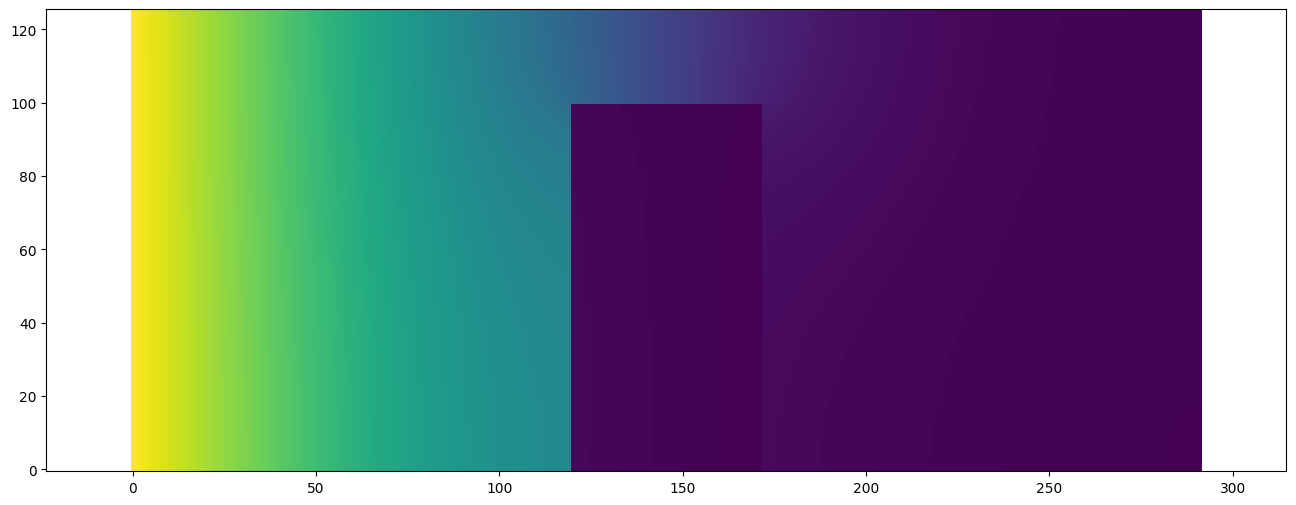

In [132]:
import matplotlib
ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=100, interpolation='nearest')

In [133]:
ps.jupyter.display_as_html_video(ani)

In [111]:
np.sum(c_arr[1:-1,1:-1])

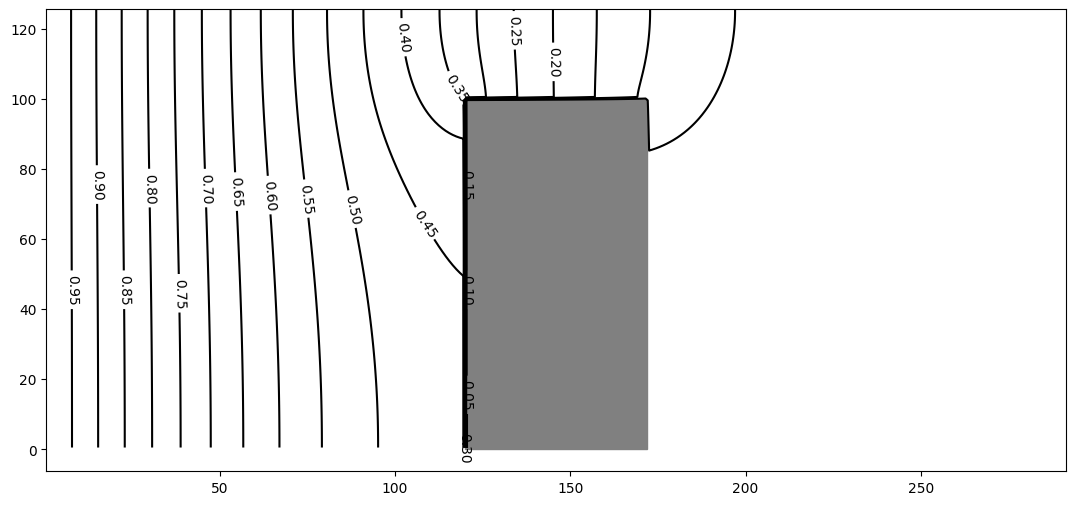

In [130]:
fig, ax  = plt.subplots()
ax.set_aspect('equal')
c = ax.contour(c_arr.T, origin = "lower", colors = "black", levels = np.arange(0, 1, 0.05))
ax.clabel(c, inline=True)
rect = patches.Rectangle((l1, 0), s, h, color = "grey")
ax.add_patch(rect)

/tmp/ipykernel_4134/45889642.py:3: UserWarning: No contour levels were found within the data range.
  c = ax.contour(ρ_arr.T, origin = "lower", colors = "black")#, levels = np.arange(0, 1, 0.05))


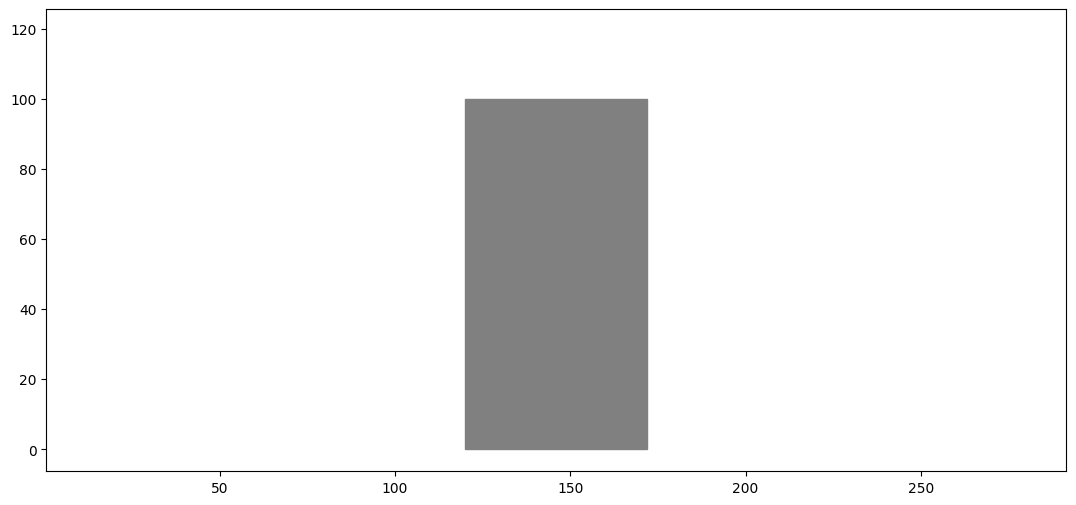

In [68]:
fig, ax  = plt.subplots()
ax.set_aspect('equal')
c = ax.contour(ρ_arr.T, origin = "lower", colors = "black")#, levels = np.arange(0, 1, 0.05))
ax.clabel(c, inline=True)
rect = patches.Rectangle((l1, 0), s, h, color = "grey")
ax.add_patch(rect)

In [113]:
np.min(c_arr)

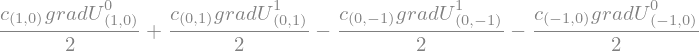

In [144]:
ps.fd.Discretization2ndOrder(dx = 1)(ps.fd.advection(c, gradU))